In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [59]:
import matplotlib.pyplot as plt 
import torch.nn.functional as F 
import torch 
import numpy as np 

def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['0','1','10','11','2','3','4','5','6','8']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    print('ps=',ps)
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [6]:
class CFG:

    epochs =20                              # No. of epochs for training the model
    lr = 0.001                              # Learning rate
    batch_size = 16                         # Batch Size for Dataset

    model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
    img_size = 224                          # Resize all the images to be 224 by 224
  
    train_path='cleaned_employee_dataset_new'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))


  

On which device we are on:cuda


In [7]:
from torchvision import transforms as T,datasets

In [8]:
train_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
#                              T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [10]:
import os

os.rmdir('cleaned_employee_dataset_new/7')

In [11]:
empl_dataset=datasets.ImageFolder(root='cleaned_employee_dataset_new',transform=train_transform)
print("Trainset Size:  {}".format(len(empl_dataset)))

Trainset Size:  13903


In [12]:
trainset, valset = torch.utils.data.random_split(empl_dataset, [11000, 2903])

In [13]:
len(trainset)

11000

In [14]:
len(valset)

2903

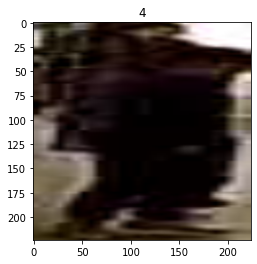

In [15]:
img,label = trainset[1000]
#print(trainset.class_to_idx)

class_name =class_name = ['0','1','2','3','4','5','6','8','10','11']
show_image(img,class_name[label])

In [16]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [17]:
trainloader = DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:688
No. of Total examples:11000


In [18]:
validationloader = DataLoader(valset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in validationloader:182
No. of Total examples:2903


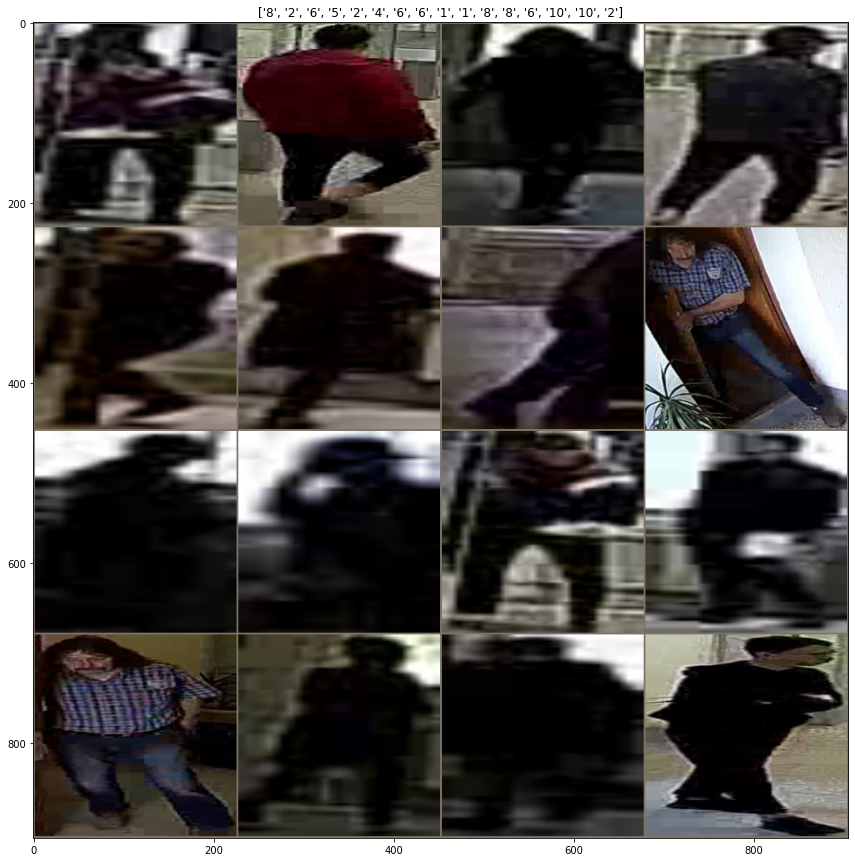

In [19]:
for dataiter in trainloader:
    images,labels = dataiter

    out = make_grid(images,nrow=4)

    show_grid(out,title = [class_name[x] for x in labels])
    break

In [23]:
!pip install timm # install PyTorch Image Models

In [20]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model(CFG.model_name,pretrained=True) #load pretrained model

/usr/local/lib/python3.8/dist-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [21]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [22]:
#let's update the pretarined model:
for param in model.parameters():
    param.requires_grad=False

#orginally, it was:
#(classifier): Linear(in_features=1792, out_features=1000, bias=True)


#we are updating it as a 2-class classifier:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10), 
)

model

# after updatingnow it becomes:
#(classifier): Sequential(
#    (0): Linear(in_features=1792, out_features=625, bias=True)
#    (1): ReLU()
#    (2): Dropout(p=0.3, inplace=False)
#    (3): Linear(in_features=625, out_features=256, bias=True)
#    (4): ReLU()
#    (5): Linear(in_features=256, out_features=2, bias=True)
#  )

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [23]:
# from torchsummary import  summary
model.to(device) # move the model to GPU
# summary(model,input_size=(3,224,224))

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [24]:
class EmplTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'EmplDetectModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = EmplTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Valid_loss decreased inf --> 1.0743076686675732
Epoch : 1 Train Loss : 1.420986 Train Acc : 0.499818
Epoch : 1 Valid Loss : 1.074308 Valid Acc : 0.625294


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Valid_loss decreased 1.0743076686675732 --> 0.9014316895505884
Epoch : 2 Train Loss : 1.039090 Train Acc : 0.638263
Epoch : 2 Valid Loss : 0.901432 Valid Acc : 0.686028


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Valid_loss decreased 0.9014316895505884 --> 0.8065057073484411
Epoch : 3 Train Loss : 0.886166 Train Acc : 0.690498
Epoch : 3 Valid Loss : 0.806506 Valid Acc : 0.723263


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Valid_loss decreased 0.8065057073484411 --> 0.7685262983316904
Epoch : 4 Train Loss : 0.779822 Train Acc : 0.728652
Epoch : 4 Valid Loss : 0.768526 Valid Acc : 0.744898


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Valid_loss decreased 0.7685262983316904 --> 0.7675688926662717
Epoch : 5 Train Loss : 0.717481 Train Acc : 0.749182
Epoch : 5 Valid Loss : 0.767569 Valid Acc : 0.751325


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Valid_loss decreased 0.7675688926662717 --> 0.6883956862838714
Epoch : 6 Train Loss : 0.667538 Train Acc : 0.768259
Epoch : 6 Valid Loss : 0.688396 Valid Acc : 0.771340


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.613548 Train Acc : 0.785429
Epoch : 7 Valid Loss : 0.690986 Valid Acc : 0.768593


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Valid_loss decreased 0.6883956862838714 --> 0.6757452112141547
Epoch : 8 Train Loss : 0.572699 Train Acc : 0.800963
Epoch : 8 Valid Loss : 0.675745 Valid Acc : 0.780465


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Valid_loss decreased 0.6757452112141547 --> 0.6523068911999792
Epoch : 9 Train Loss : 0.544467 Train Acc : 0.809866
Epoch : 9 Valid Loss : 0.652307 Valid Acc : 0.792484


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Valid_loss decreased 0.6523068911999792 --> 0.6319174658875544
Epoch : 10 Train Loss : 0.510010 Train Acc : 0.823129
Epoch : 10 Valid Loss : 0.631917 Valid Acc : 0.800383


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.481815 Train Acc : 0.833031
Epoch : 11 Valid Loss : 0.650226 Valid Acc : 0.795918


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Valid_loss decreased 0.6319174658875544 --> 0.6263756084941573
Epoch : 12 Train Loss : 0.474297 Train Acc : 0.837391
Epoch : 12 Valid Loss : 0.626376 Valid Acc : 0.801315


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Valid_loss decreased 0.6263756084941573 --> 0.6117723822634626
Epoch : 13 Train Loss : 0.469077 Train Acc : 0.840843
Epoch : 13 Valid Loss : 0.611772 Valid Acc : 0.806809


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.427617 Train Acc : 0.854197
Epoch : 14 Valid Loss : 0.622559 Valid Acc : 0.808870


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Valid_loss decreased 0.6117723822634626 --> 0.610174682390477
Epoch : 15 Train Loss : 0.421554 Train Acc : 0.854651
Epoch : 15 Valid Loss : 0.610175 Valid Acc : 0.814806


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.405925 Train Acc : 0.858739
Epoch : 16 Valid Loss : 0.620533 Valid Acc : 0.816179


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.394561 Train Acc : 0.862009
Epoch : 17 Valid Loss : 0.621471 Valid Acc : 0.813579


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Valid_loss decreased 0.610174682390477 --> 0.5884264809089702
Epoch : 18 Train Loss : 0.388746 Train Acc : 0.868187
Epoch : 18 Valid Loss : 0.588426 Valid Acc : 0.825353


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.351459 Train Acc : 0.879270
Epoch : 19 Valid Loss : 0.614077 Valid Acc : 0.819712


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.364916 Train Acc : 0.874182
Epoch : 20 Valid Loss : 0.625137 Valid Acc : 0.821085


In [30]:
# model.load_state_dict(torch.load('EmplDetectModel.pt'))
# model.eval()

# avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


# print("Test Loss : {}".format(avg_test_loss))
# print("Test Acc : {}".format(avg_test_acc))

ps= [2.9117298e-06 7.6589714e-16 6.5681445e-12 1.9388095e-11 1.2121981e-11
 3.0817350e-08 9.9999714e-01 6.9127293e-10 1.6011381e-09 8.6669073e-16]


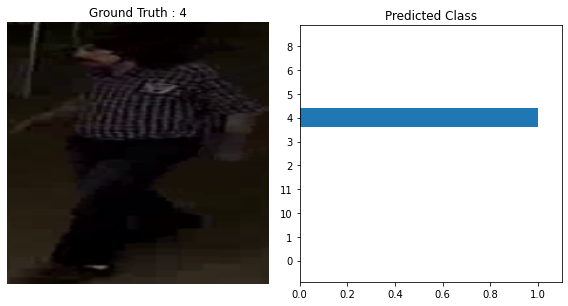

In [61]:
import torch.nn.functional as F

image,label = valset[28]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)